# Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score

# reading csv data
data = pd.read_csv("./data/fashion-mnist_train.csv")
images = data.iloc[:, 1:]
labels = data.iloc[:, 0]
label_map = {0: 'T-shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle'}

# function that turns number to string labels
def label_str(label):
    return label_map[label]


# scaling and normalizing the data
scaler = StandardScaler()
images_scaled = pd.DataFrame(scaler.fit_transform(images))
images_norm = normalize(images_scaled)

# dimensionality reduction
pca = PCA(n_components = 784)
data_pca = pca.fit_transform(images_norm)
data_pca = pd.DataFrame(data_pca, columns=["PC{}".format(n) for n in range(1, 785)])

# determining the cut-off
cum_sum = np.cumsum(pca.explained_variance_ratio_)
pca_dims = np.argmax(cum_sum >= 0.95) + 1

# LDA dimensionality reduction
Page 11 in the project report

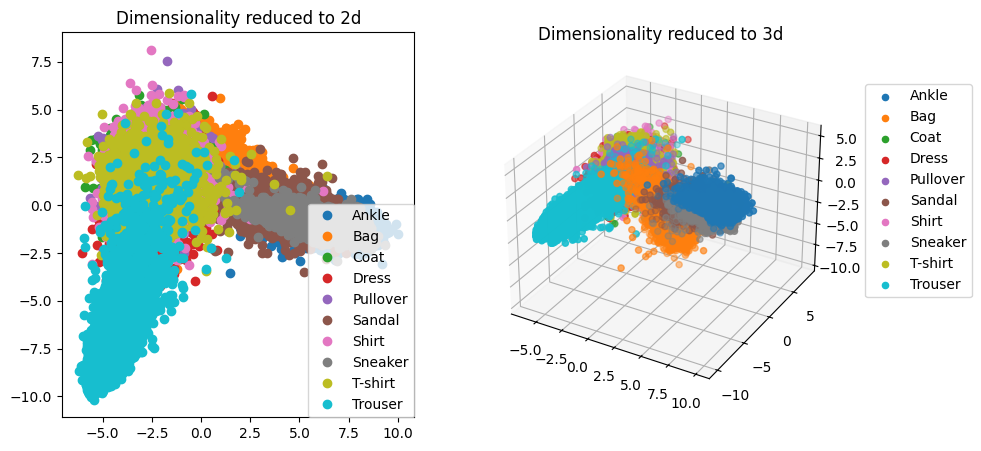

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# initializing LDA for dimensionality reduction to 3 components
lda = LinearDiscriminantAnalysis(n_components=3)

# fit and transform the data
X_lda = lda.fit_transform(images_norm, labels)

data_lda=pd.DataFrame(X_lda, columns=["LDA{}".format(n) for n in range(1,4)])
data_lda["type"] = labels.map(label_map)

# plotting the dataset in reduced-dimensionality space
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[1].remove()
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

groups = data_lda.groupby("type")

for name, group in groups:
    # 2-d space
    axs[0].scatter(group["LDA1"], group["LDA2"], marker="o", linestyle="", label=name)
    # 3-d space
    ax2.scatter(group["LDA1"], group["LDA2"], group["LDA3"], marker="o", label=name)
    

axs[0].legend(loc='lower right', borderaxespad=0)
t=axs[0].set_title("Dimensionality reduced to 2d")
   
ax2.legend(bbox_to_anchor=(1.08, 0.9), loc='upper left', borderaxespad=0)
ax2.set_title("Dimensionality reduced to 3d");

# DBSCAN clustering
Page 12 in the project report

0.048093898092792534


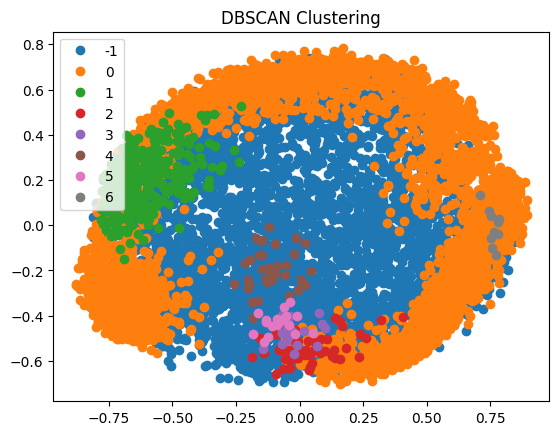

In [3]:
from sklearn.cluster import DBSCAN

# applying DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')
db_labels = dbscan.fit_predict(data_pca.iloc[:10000, 0:pca_dims])

print(adjusted_rand_score(labels.iloc[:10000], db_labels))

df = data_pca.iloc[:10000, 0:pca_dims]
df["type"] = db_labels
df["real_type"] = labels.iloc[:10000]

# plotting the results
fig, ax = plt.subplots()
groups = df.groupby("type")
for name, group in groups:
    ax.scatter(group["PC1"], group["PC2"], marker="o", linestyle="", label=name)


ax.legend()
ax.set_title("DBSCAN Clustering");

# Random tree forest classification
Page 13 in the project report

Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.81      1232
           1       0.99      0.94      0.96      1174
           2       0.78      0.78      0.78      1200
           3       0.83      0.89      0.86      1242
           4       0.72      0.78      0.75      1185
           5       0.89      0.91      0.90      1141
           6       0.68      0.50      0.58      1243
           7       0.91      0.88      0.90      1224
           8       0.89      0.96      0.92      1149
           9       0.91      0.95      0.93      1210

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000


Text(0.5, 1.0, 'Last Tree from Random Forest')

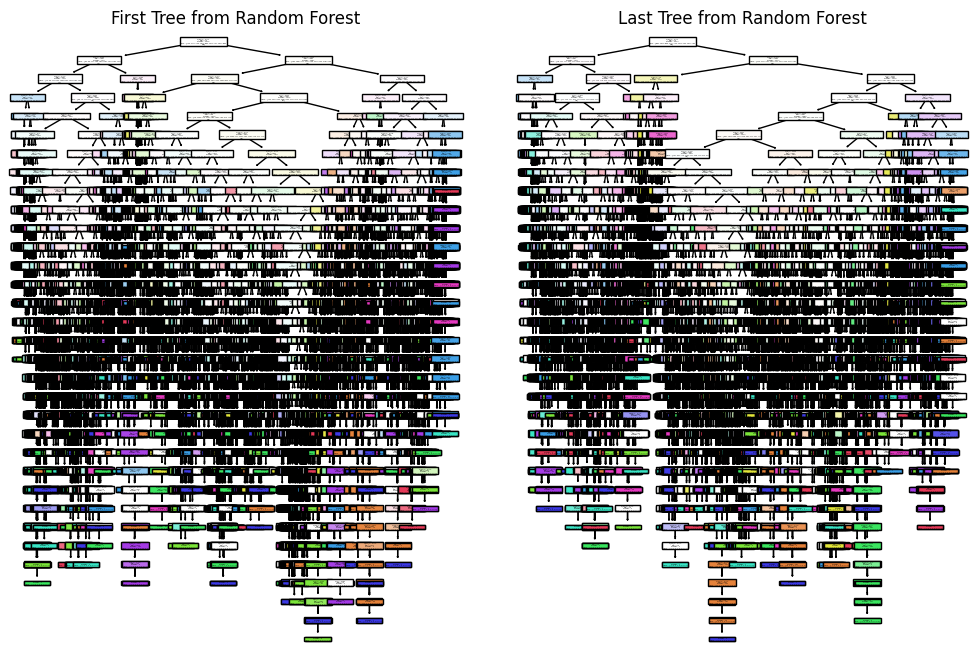

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

# splitting the dataset into test and training subsets
X_train, X_test, y_train, y_test = train_test_split(data_pca, labels, test_size=0.2, random_state=42)

# initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# training the classifier on the training data
rf_classifier.fit(X_train, y_train)
# making predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# evaluating the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_output)

first_tree = rf_classifier.estimators_[0]
last_tree = rf_classifier.estimators_[-1]

# plotting the first and last trees
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_tree(first_tree, filled=True)
plt.title('First Tree from Random Forest')

plt.subplot(1, 2, 2)
plot_tree(last_tree, filled=True)
plt.title('Last Tree from Random Forest')

# LDA classification
Page 13 in the project report

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# initializing the LDA classifier
lda_classifier = LinearDiscriminantAnalysis()

# setting up k-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
# performing 5-Fold cross-validation
for train_index, test_index in kfold.split(data_pca):
    X_train, X_test = data_pca.iloc[train_index], data_pca.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # fitting the LDA model
    lda_classifier.fit(X_train, y_train)

    # making predictions
    y_pred = lda_classifier.predict(X_test)

    # calculating accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)
    print(accuracy)


# calculate the average accuracy across folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Average Accuracy: {average_accuracy:.2f}")

0.8248333333333333
0.8301666666666667
0.8261666666666667
0.82425
0.8269166666666666
Average Accuracy: 0.83
